In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Unstructured data analytics with BigQuery ML and Vertex AI pre-trained models

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/bigquery_ml/bq_ml_with_vision_translation_nlp.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/bigquery_ml/bq_ml_with_vision_translation_nlp.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/bigquery_ml/bq_ml_with_vision_translation_nlp.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.9

## Overview
In this tutorial, you learn how to analyze unstructured data within BigQuery using BigQuery's inference engine. You will use BigQuery ML to connect to three pretrained Vertex AI APIs - Vision API, Translation API and Natural Language Processing API.


### Objectives
The objective is to demonstrate how to detect and translate text from movie poster images, and run sentiment analysis against movie reviews.

You can find out more in the blog: [How to simplify unstructured data analytics using BigQuery ML and Vertex AI](https://cloud.google.com/blog/products/data-analytics/how-simplify-unstructured-data-analytics-using-bigquery-ml-and-vertex-ai)

<br>

The steps to perform include:

- Define pre-trained models for Vision AI, Translation AI and NLP AI in BigQuery ML
- Cal the Vision API (`ML.ANNOTATE_IMAGE`) to detect text in images stored in Cloud Storage
  You will need to create an object table in BigQuery to do this
- Call the Translation API (`ML.TRANSLATE`) to detect the language of text, and translate non-English movie titles to English
- Call the Natural Language API (`ML.UNDERSTAND_TEXT`) to run sentiment analysis over movie reviews stored in BigQuery


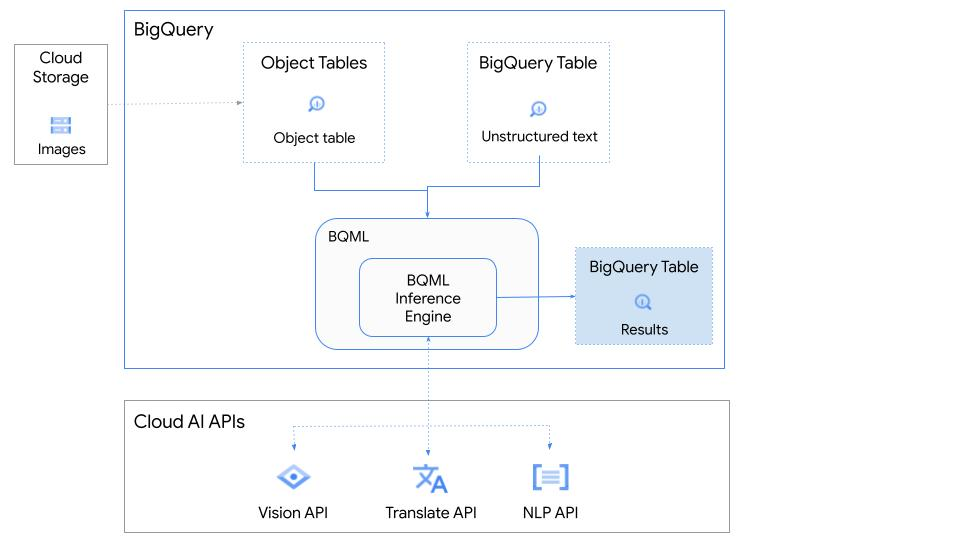

### Dataset
The dataset will use a collection of movie poster images stored in a Google Cloud Storage bucket: [gs://cloud-samples-data/vertex-ai/dataset-management/datasets/classic-movie-posters](https://console.cloud.google.com/storage/browser/cloud-samples-data/vertex-ai/dataset-management/datasets/classic-movie-posters)

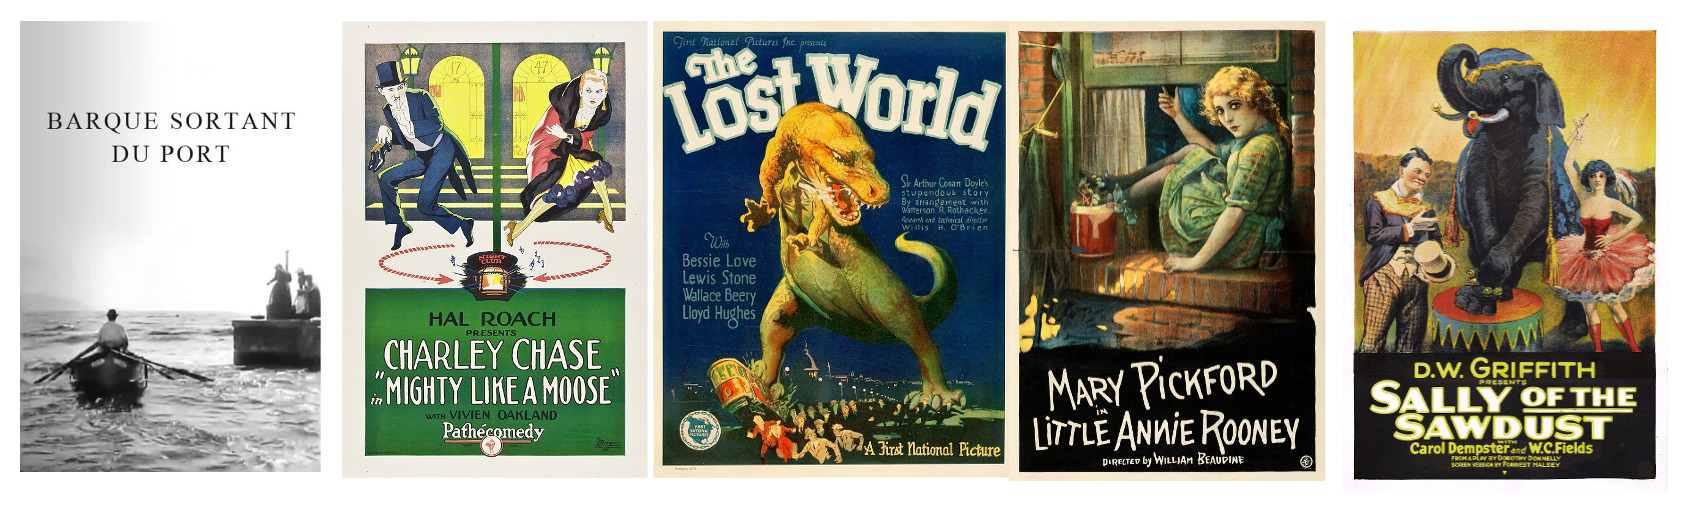

### Services and Costs
This tutorial uses the following Google Cloud data analytics and ML services, they are billable components of Google Cloud:

* BigQuery <a href="https://cloud.google.com/bigquery/pricing" target="_blank">(pricing)</a>
* BigQuery ML <a href="https://cloud.google.com/bigquery-ml/pricing" target="_blank">(pricing)</a>
* Vision AI API <a href="https://cloud.google.com/vision/pricing" target="_blank">(pricing)</a>
*  Translation AI API <a href="https://cloud.google.com/translate/pricing/" target="_blank">(pricing)</a>
* Natural Language AI API <a href="https://cloud.google.com/natural-language/pricing" target="_blank">(pricing)</a>

Check out the [BQML Pricing page](https://cloud.google.com/bigquery/pricing#bqml) for a breakdown of costs are applied across these services.

Use the [Pricing
Calculator](https://cloud.google.com/products/calculator)
to generate a cost estimate based on your projected usage.

### Installation

Install the following packages required to execute this notebook.

In [ ]:
!pip install google-cloud-bigquery-connection

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable BigQuery Connection API](https://console.cloud.google.com/apis/library/bigqueryconnection.googleapis.com?_ga=2.83970457.1667545569.1683624898-1324157630.1682064685),
[Enable Vision AI API](https://console.cloud.google.com/flows/enableapi?apiid=vision.googleapis.com&_ga=2.142627317.1555751656.1683019757-1324157630.1682064685),
[Enable Translation AI API](https://console.cloud.google.com/flows/enableapi?apiid=translate.googleapis.com&_ga=2.142627317.1555751656.1683019757-1324157630.1682064685), [Enable NLP AI API](https://console.cloud.google.com/flows/enableapi?apiid=language.googleapis.com&_ga=2.83970457.1667545569.1683624898-1324157630.1682064685)

4. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

#### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "your-project-id"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "US"  # @param {type: "string"}

#### Setup Project Variables

In [ ]:
DATASET_ID = "bqml_tutorial"
OBJECT_TABLE_NAME = "obj_cloud_ai_images"
CONN_NAME = "bqml_inference_conn"
CONN_SERVICE_ACCOUNT = ""
VISION_MODEL_NAME = "bqml-cloud-ai-vision"
TRANSLATE_MODEL_NAME = "bqml-cloud-ai-translation"
NLP_MODEL_NAME = "bqml-cloud-ai-nlp"
BUCKET_LOC = "gs://cloud-samples-data/vertex-ai/dataset-management/datasets/classic-movie-posters"

### Authenticate to your Google Cloud account
Run the cell below and follow the instructions when prompted to authenticate your account via OAuth.

In [ ]:
from google.colab import auth

auth.authenticate_user()

### Import libraries


In [ ]:
from google.cloud import bigquery
from google.cloud import bigquery_connection_v1 as bq_connection

### Create BigQuery Cloud resource connection
You will need to create a [Cloud resource connection](https://cloud.google.com/bigquery/docs/create-cloud-resource-connection) to enable BigQuery to interact with Vertex AI services.

In [ ]:
client = bq_connection.ConnectionServiceClient()
new_conn_parent = f"projects/{PROJECT_ID}/locations/{REGION}"
exists_conn_parent = f"projects/{PROJECT_ID}/locations/{REGION}/connections/{CONN_NAME}"
cloud_resource_properties = bq_connection.CloudResourceProperties({})

try:
    request = client.get_connection(
        request=bq_connection.GetConnectionRequest(name=exists_conn_parent)
    )
    CONN_SERVICE_ACCOUNT = f"serviceAccount:{request.cloud_resource.service_account_id}"
except Exception:
    connection = bq_connection.types.Connection(
        {"friendly_name": CONN_NAME, "cloud_resource": cloud_resource_properties}
    )
    request = bq_connection.CreateConnectionRequest(
        {
            "parent": new_conn_parent,
            "connection_id": CONN_NAME,
            "connection": connection,
        }
    )
    response = client.create_connection(request)
    CONN_SERVICE_ACCOUNT = (
        f"serviceAccount:{response.cloud_resource.service_account_id}"
    )
print(CONN_SERVICE_ACCOUNT)

### Set permissions for Service Account
The resource connection service account requires certain project-level permissions which are outlined in the <a href="https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-cloud-ai-service-tvfs-overview#grant_access_to_the_service_account" target="_blank">inference function documentation</a>.

In [ ]:
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/serviceusage.serviceUsageConsumer'
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/bigquery.connectionUser'
!gcloud projects add-iam-policy-binding {PROJECT_ID} --condition=None --no-user-output-enabled --member={CONN_SERVICE_ACCOUNT} --role='roles/cloudtranslate.user'

## Prepare BigQuery Dataset

### Create a BigQuery Dataset
You will need a BigQuery dataset to store your ML models. Run the following to create a dataset within your project called **bqml_tutorial**:

In [ ]:
client = bigquery.Client(project=PROJECT_ID)
dataset = client.create_dataset(DATASET_ID, exists_ok=True)
print(f"Dataset {dataset.dataset_id} created.")

Create wrapper to use BigQuery client to run query and return result

In [ ]:
# Wrapper to use BigQuery client to run query and return result
def run_bq_query(sql: str):
    """
    Input: SQL query, as a string, to execute in BigQuery
    Returns the query results or error, if any
    """
    try:
        query_job = client.query(sql)
        result = query_job.result()
        print(f"JOB ID: {query_job.job_id} STATUS: {query_job.state}")
        return result

    except Exception as e:
        raise Exception(str(e))

### Create object table in BigQuery (only required for Vision AI API)
You will need to create an [object table](https://cloud.google.com/bigquery/docs/object-table-introduction) for your images in Cloud Storage. This read-only object table provides metadata for images stored in Cloud Storage.

In [ ]:
sql = f"""
      CREATE OR REPLACE EXTERNAL TABLE
        `{PROJECT_ID}.{DATASET_ID}.{OBJECT_TABLE_NAME}`
      WITH
        CONNECTION `{REGION}.{CONN_NAME}`
        OPTIONS
          (object_metadata = 'SIMPLE', uris = ['{BUCKET_LOC}/*']);
      """
result = run_bq_query(sql)

Querying the table will show you the metadata for the images stored in the bucket. For example, you can see the uri for all the movie posters, the content type and size.

In [ ]:
sql = f"""
        SELECT
            *
        FROM
            `{PROJECT_ID}.{DATASET_ID}.{OBJECT_TABLE_NAME}`
        LIMIT
            50;
      """
result = run_bq_query(sql)
result.to_dataframe().head(10)

## Call Vision, Translation and NLP APIs to analyze unstructured data


Vertex AI service [table-valued functions (TVFs)](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-cloud-ai-service-tvfs-overview) allow you to access services such as Cloud Vision API, Cloud Translation API and Cloud Natural Language API directly from BigQuery. You create and interact with them as you would a BQML model, and when called, they work by calling the pre-trained models provided through Vertex AI on your behalf.

You will first create your remote Vertex AI models to be used with the Vision API, Translation API and NLP API.

### Call Vision AI API to detect text in movie posters
First, create the Vision AI remote model.

In [ ]:
sql = f"""
      CREATE OR REPLACE MODEL
        `{PROJECT_ID}.{DATASET_ID}.{VISION_MODEL_NAME}`
      REMOTE WITH
          CONNECTION `{PROJECT_ID}.{REGION}.{CONN_NAME}`
          OPTIONS ( remote_service_type = 'cloud_ai_vision_v1' );
        """
result = run_bq_query(sql)

Next use the Vision AI `(ML.ANNOTATE_IMAGE)` function with the `text_detection` feature to detect the text from the posters defined in our object table.

In [ ]:
sql = f"""
      CREATE OR REPLACE TABLE
        `{PROJECT_ID}.{DATASET_ID}.image_results` AS
      SELECT
        --this column must be named 'text_content' for the next step
        REPLACE(
          STRING(
            ml_annotate_image_result.full_text_annotation.text),
            '\\n', ' '
        ) AS text_content,
        *
      FROM
        ML.ANNOTATE_IMAGE(
          MODEL `{PROJECT_ID}.{DATASET_ID}.{VISION_MODEL_NAME}`,
          TABLE `{DATASET_ID}.{OBJECT_TABLE_NAME}`,
          STRUCT(['TEXT_DETECTION'] AS vision_features));
      """
run_bq_query(sql)

A JSON response will be returned to BigQuery that includes the text content and language code of the text.

You can parse the JSON to a scalar result using the dot annotation highlighted above.

You should be able to find the text content for these posters in the results below.


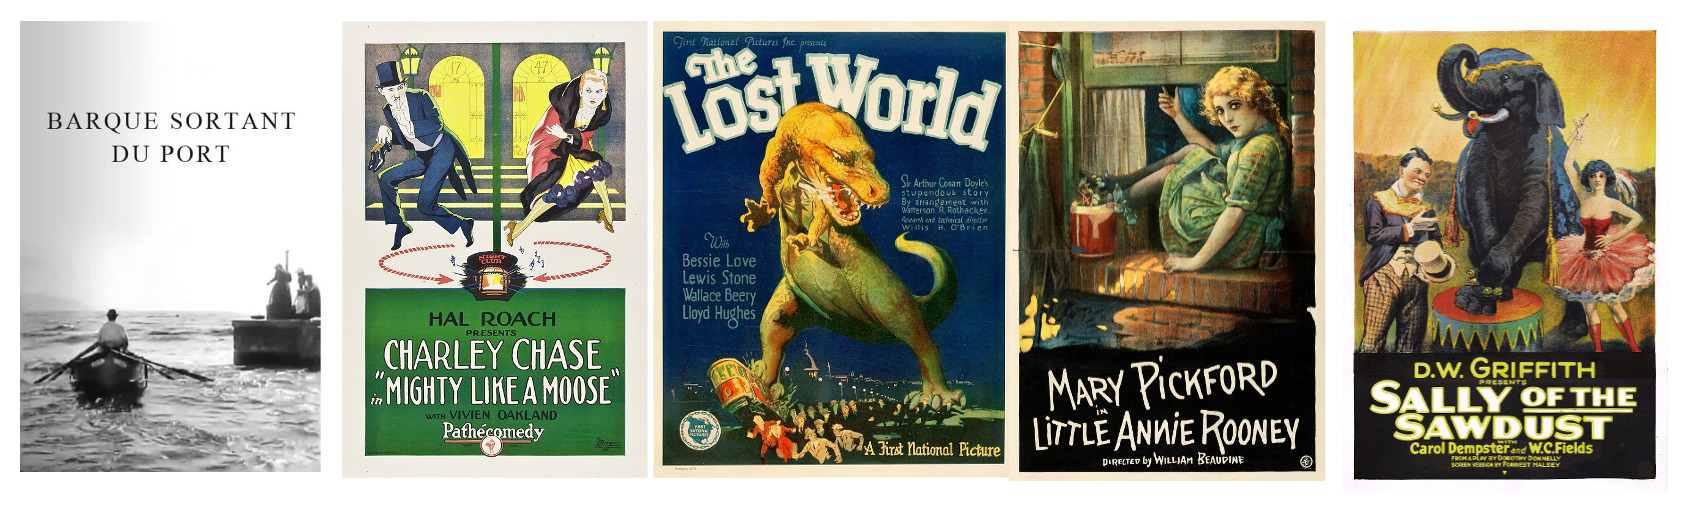

In [ ]:
sql = f"""
        SELECT
          text_content,
          uri,
          content_type,
          ml_annotate_image_result
        FROM
          `{PROJECT_ID}.{DATASET_ID}.image_results`
      """
result = run_bq_query(sql)
result.to_dataframe().head(20)

### Call Translation AI API to translate foreign titles to English
Create the remote model for Translation AI API

In [ ]:
sql = f"""
      CREATE OR REPLACE MODEL
        `{PROJECT_ID}.{DATASET_ID}.{TRANSLATE_MODEL_NAME}`
        REMOTE WITH CONNECTION
          `{PROJECT_ID}.{REGION}.{CONN_NAME}`
          OPTIONS ( remote_service_type = 'cloud_ai_translate_v3');
      """
result = run_bq_query(sql)

Next, use the Translate AI (`ML.TRANSLATE`) function with the `translate_text` feature to translate non-English text from the posters to English.

*Note: The table column with the text you want to translate must be named text_content*


In [ ]:
sql = f"""
        CREATE OR REPLACE TABLE
          `{PROJECT_ID}.{DATASET_ID}.translated_results` AS
        SELECT
          STRING(ml_translate_result.translations[0].detected_language_code)
           as original_language,
          STRING(ml_translate_result.translations[0].translated_text)
           as translated_title,
          *
        FROM
          ML.TRANSLATE(
            MODEL `{PROJECT_ID}.{DATASET_ID}.{TRANSLATE_MODEL_NAME}`,
            TABLE `{DATASET_ID}.image_results`,
            STRUCT(
            'TRANSLATE_TEXT' as translate_mode,
            "en" as target_language_code
            )
          );
        """
result = run_bq_query(sql)

The table of results will include JSON that can be parsed to extract both the original language and the translated text.
In this case, the model has detected that title text is in French and has translated it to English

In [ ]:
sql = f"""
        SELECT
          text_content, original_language, translated_title
        FROM
          `{PROJECT_ID}.{DATASET_ID}.translated_results`
        WHERE
          original_language = 'fr'
        """

result = run_bq_query(sql)
result.to_dataframe().head(20)

### Call NLP AI API to analyze the sentiment of movie reviews
The final model to create is the NLP remote model


In [ ]:
sql = f"""
      CREATE OR REPLACE MODEL
        `{PROJECT_ID}.{DATASET_ID}.{NLP_MODEL_NAME}`
      REMOTE WITH CONNECTION `{PROJECT_ID}.{REGION}.{CONN_NAME}`
        OPTIONS ( remote_service_type = 'cloud_ai_natural_language_v1');
      """
result = run_bq_query(sql)

You can now join the movie titles extracted from our posters with thousands of movie reviews stored in BigQuery’s IMDB public dataset `bigquery-public-data.imdb.reviews`.

Next, use the Natural Language AI (`ML.UNDERSTAND_TEXT`) function with the `analyze_sentiment` feature to run sentiment analysis against some of these reviews to determine whether they are positive or negative.

In [ ]:
sql = f"""
        SELECT
          primary_title, start_year, text_content AS review,
          FLOAT64(
            ml_understand_text_result.document_sentiment.score
          ) AS score,
          FLOAT64(
            ml_understand_text_result.document_sentiment.magnitude
          ) AS magnitude,
        FROM
          ML.UNDERSTAND_TEXT(
            MODEL `{PROJECT_ID}.{DATASET_ID}.{NLP_MODEL_NAME}`,
              (
                SELECT
                  primary_title, start_year, review AS text_content
                FROM
                  `bigquery-public-data.imdb.title_basics` titles
                JOIN
                  `bigquery-public-data.imdb.reviews` reviews
                ON
                  reviews.movie_id = titles.tconst
                WHERE
                  UPPER(titles.primary_title) = 'THE LOST WORLD' AND
                  start_year = 1925
              ),
            STRUCT("analyze_sentiment" AS nlu_option)) ;
        """
results = run_bq_query(sql)

The JSON response will include a score and magnitude. The score indicates the overall emotion of the text while the magnitude indicates how much emotional content is present.

In [ ]:
results.to_dataframe().round(3).head(10)

### So, how did the Lost World compare with other movies that year?

To wrap up, compare the average review score of 1925 release of The Lost World movie to other movies released that year to see which was most popular.

In [ ]:
sql = f"""
        SELECT
            primary_title,
            start_year,
            AVG(
                FLOAT64(
                    ml_understand_text_result.document_sentiment.score)
            ) AS av_score,
            AVG(
                FLOAT64(
                    ml_understand_text_result.document_sentiment.magnitude)
            ) AS av_magnitude
        FROM
            ML.UNDERSTAND_TEXT(
                MODEL `{PROJECT_ID}.{DATASET_ID}.{NLP_MODEL_NAME}`,
                (
                    SELECT
                        primary_title,
                        start_year,
                        movie_id,
                        review AS text_content
                    FROM
                        `bigquery-public-data.imdb.title_basics` titles
                        JOIN `bigquery-public-data.imdb.reviews` reviews ON reviews.movie_id = titles.tconst
                    WHERE
                        start_year = 1925
                ),
                STRUCT("analyze_sentiment" AS nlu_option)
            )
        GROUP BY
            primary_title,
            start_year
        ORDER BY
            av_score DESC;
        """
results = run_bq_query(sql)
results.to_dataframe().round(3).head(10)

It looks like The Lost World narrowly missed out on the top spot to Sally of the Sawdust!

## Cleaning Up
To clean up all Google Cloud resources used in this project, you can <a href="https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects" target="_blank">delete the Google Cloud
project</a> you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
# Delete BigQuery dataset, including the BigQuery ML models you just created, and the BigQuery Connection
! bq rm -r -f $PROJECT_ID:$DATASET_ID
! bq rm --connection --project_id=$PROJECT_ID --location=$REGION $CONN_NAME